# PCA from scratch in Python

In this notebook I'll try to implement PCA from scratch in two different ways: using eigendecomposition and using SVD.
In the end you'll also see a result produced by `scikit` and comparison of all three results along with my conclusion.

## Setup

Importing libraries and setting plot style to dark.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition

plt.style.use("dark_background")

These are helper functions for building graphs later.

In [3]:
def plot_pcs_variances(labels, variances):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    components = len(labels) + 1

    ax1.bar(labels, variances)

    ax1.set_xlabel("Principal Components")
    ax1.set_ylabel("Dataset's variance (%)")

    ax1.set_ylim((0, 100))
    ax1.grid(True)

    cumulative_variances = [0, *np.cumsum(variances)]
    ax2.plot(range(components), cumulative_variances)

    ax2.set_xlabel("Principal Components")
    ax2.set_ylabel("Cumulative variance (%)")

    ax2.set_xticks(range(components))
    ax2.set_ylim((0, 100))
    ax2.grid(True)

def plot_pc_ratios(ax, pc_vector, columns):
    sort = np.argsort(pc_vector)[::-1]

    labels = [columns[i] for i in sort]
    ratios = [pc_vector[i] for i in sort]

    ax.bar(labels, ratios)

    ax.set_xlabel("Dataset Columns")
    ax.set_ylabel("Ratio (%)")

    ax.set_ylim((-1, 1))
    ax.grid(True)

    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

In [4]:
def dot_df_pc(df: pd.DataFrame, pc: np.array):
    return np.dot(df, pc.reshape(-1, 1)).flatten()

Now, for the data. First I'll import the **Wine quality** dataset and store its columns in a separate variable.

Dataset source: [kaggle.com](https://www.kaggle.com/datasets/ruthgn/wine-quality-data-set-red-white-wine)

In [5]:
df = pd.read_csv("../data/wine-quality-white-and-red.csv")

columns = df.columns.to_list()

`WHITE_I` and `RED_I` store indexes of rows that contain data about white and red wine, respectively. Those will be used later.

In [6]:
WHITE_I = df.index[df["type"] == "white"]
RED_I = df.index[df["type"] == "red"]

Now let's drop the `type` and `quality` columns, leaving only chemical measurements in the table.

In [7]:
df_original = df

df = df.drop("type", axis=1)
df = df.drop("quality", axis=1)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


Last step before heading for PCA, we need to normalize the data, in other words, fit it into a range from 0 to 1 and then subtract its mean from it.
By doing so we make sure that dataset's mean is the origin point on the plot.

Also notice that I'm obtaining the covariance matrix here.

In [8]:
maximum = df.max()
minimum = df.min()

df_norm = (df - minimum) / (maximum - minimum)

mean = df_norm.mean(numeric_only=True, axis=0)
df = df_norm.sub(mean, axis=1)

covariance = df.cov()

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.017794,-0.046444,0.024920,0.233999,-0.018329,0.050259,0.125013,0.121522,-0.169381,-0.045656,-0.245189
1,-0.075645,-0.026444,0.012872,-0.058945,-0.011684,-0.057380,0.037455,-0.013430,0.063178,-0.023184,-0.143739
2,0.073115,-0.039777,0.049016,0.022343,-0.010023,-0.001824,-0.043190,0.007776,0.032170,-0.051274,-0.056783
3,-0.001265,-0.073111,0.000823,0.046883,0.003266,0.057204,0.161879,0.017416,-0.022094,-0.073746,-0.085768
4,-0.001265,-0.073111,0.000823,0.046883,0.003266,0.057204,0.161879,0.017416,-0.022094,-0.073746,-0.085768


## PCA with eigendecomposition

PCA with eigendecomposition is fairly straighforward: we only need to obtain eigenvalues and eigenvectors of the covariance matrix. But since we know that covariance matrix is symmetric, we can use `np.linalg.eigh`. It's faster than regular `np.linalg.eig` and also returns already sorted results.

In [9]:
eigen_values, eigen_vectors = np.linalg.eigh(covariance)

eig_values = eigen_values[::-1]
eig_components = eigen_vectors[::-1]

As you can see, PC1 holds around 37% of variance of the dataset. So by displaying PC1 through PC3, we can get up to 70% of variance.

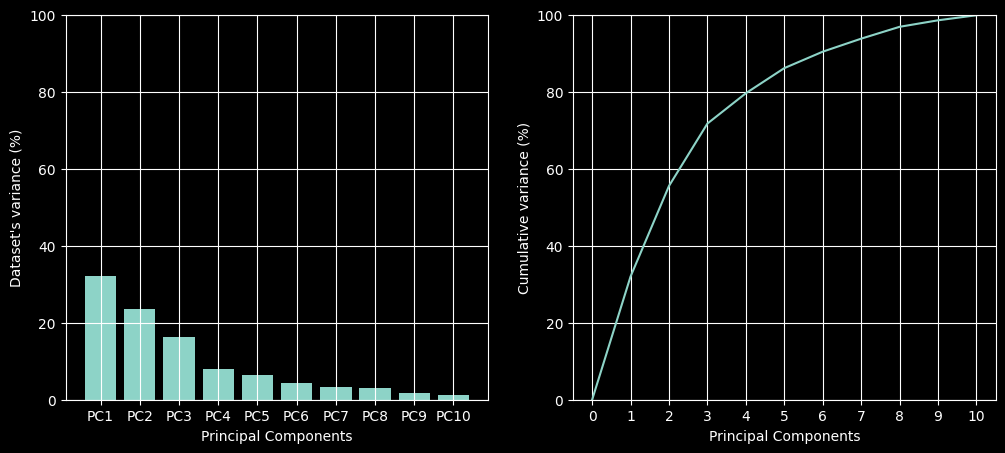

In [10]:
COMPONENTS = 10

labels = [f"PC{i + 1}" for i in range(COMPONENTS)]
eig_variances = np.round((eig_values / np.sum(eig_values) * 100)[:COMPONENTS], 3)

plot_pcs_variances(labels, eig_variances)
plt.show()

These are the ratios of parameters in PC1, PC2 and PC3.

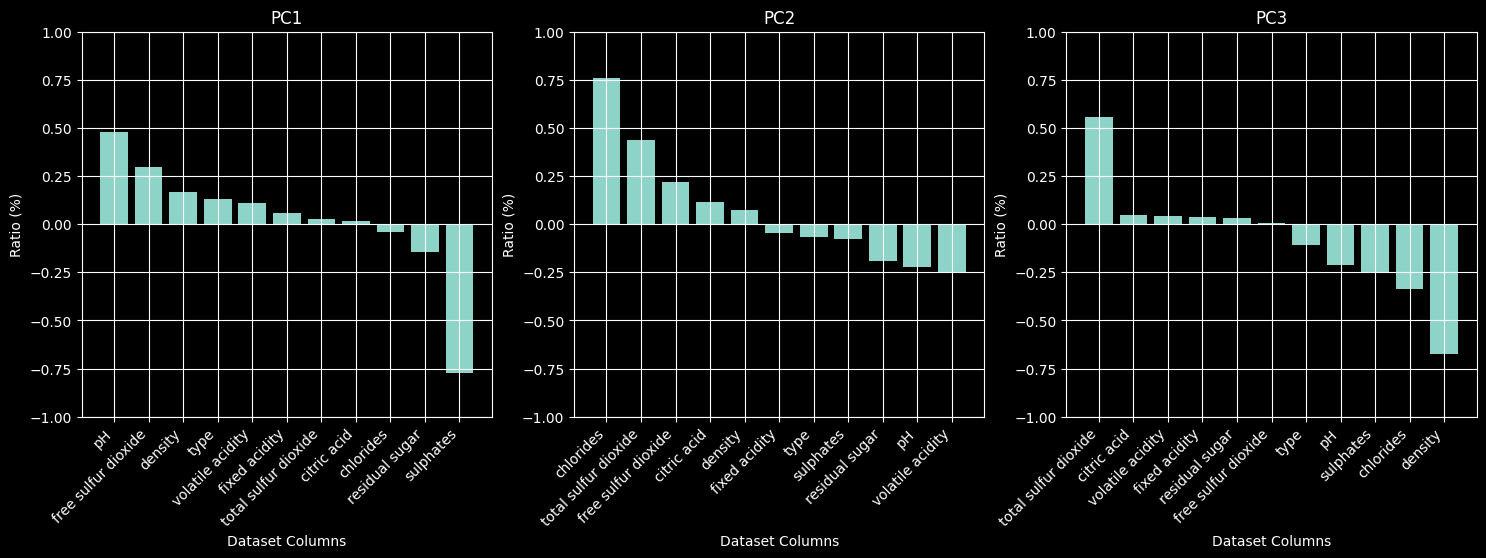

In [11]:
pc1, pc2, pc3 = eig_components[:3]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.set_title("PC1")
ax2.set_title("PC2")
ax3.set_title("PC3")

plot_pc_ratios(ax1, pc1, columns)
plot_pc_ratios(ax2, pc2, columns)
plot_pc_ratios(ax3, pc3, columns)

plt.ylim((-1, 1))
plt.show()

And these are the plots PC1 vs PC2 and even a 3D plot with PC3 included! Get 3 for the price of 2.

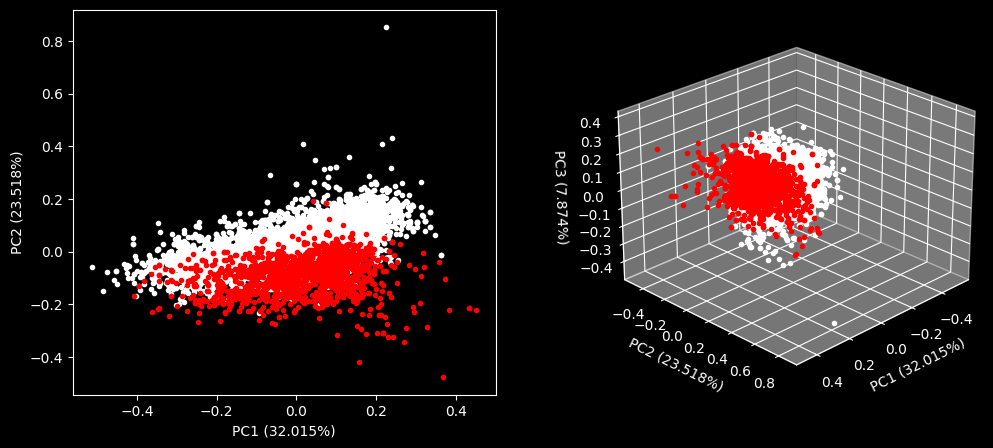

In [12]:
eig_result = np.array([dot_df_pc(df, eig_components[i]) for i in range(3)])

fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(1, 2, 1)

ax.set_xlabel(f"PC1 ({eig_variances[0]}%)")
ax.set_ylabel(f"PC2 ({eig_variances[1]}%)")

ax.plot(*eig_result[:2, WHITE_I], "w.")
ax.plot(*eig_result[:2, RED_I], "r.")


ax = fig.add_subplot(1, 2, 2, projection="3d")

ax.set_xlabel(f"PC1 ({eig_variances[0]}%)")
ax.set_ylabel(f"PC2 ({eig_variances[1]}%)")
ax.set_zlabel(f"PC3 ({eig_variances[3]}%)")

ax.plot(*eig_result[:, WHITE_I], "w.")
ax.plot(*eig_result[:, RED_I], "r.")
ax.view_init(elev=25, azim=45, roll=0)

plt.show()

## PCA with SVD

In [13]:
_, svd_values, svd_components = np.linalg.svd(covariance, full_matrices=True)

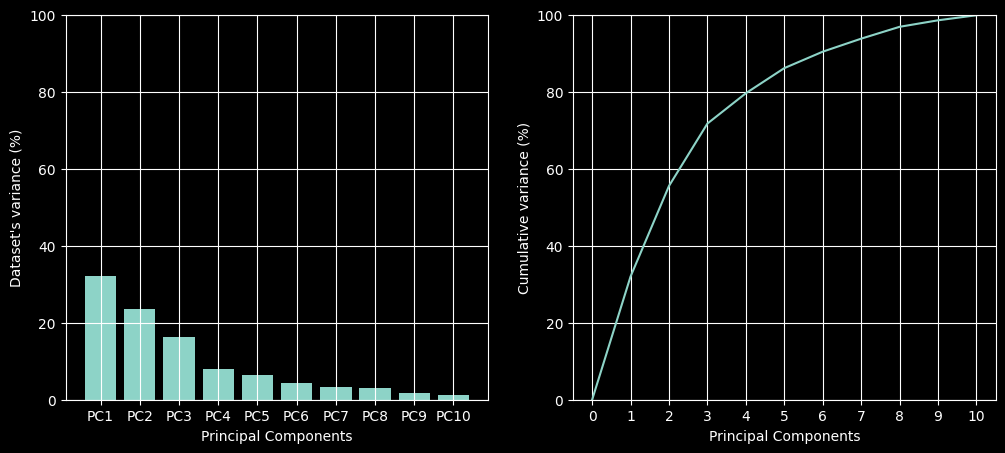

In [14]:
COMPONENTS = 10

labels = [f"PC{i + 1}" for i in range(COMPONENTS)]
svd_variances = np.round((svd_values / np.sum(svd_values) * 100)[:COMPONENTS], 3)

plot_pcs_variances(labels, svd_variances)
plt.show()

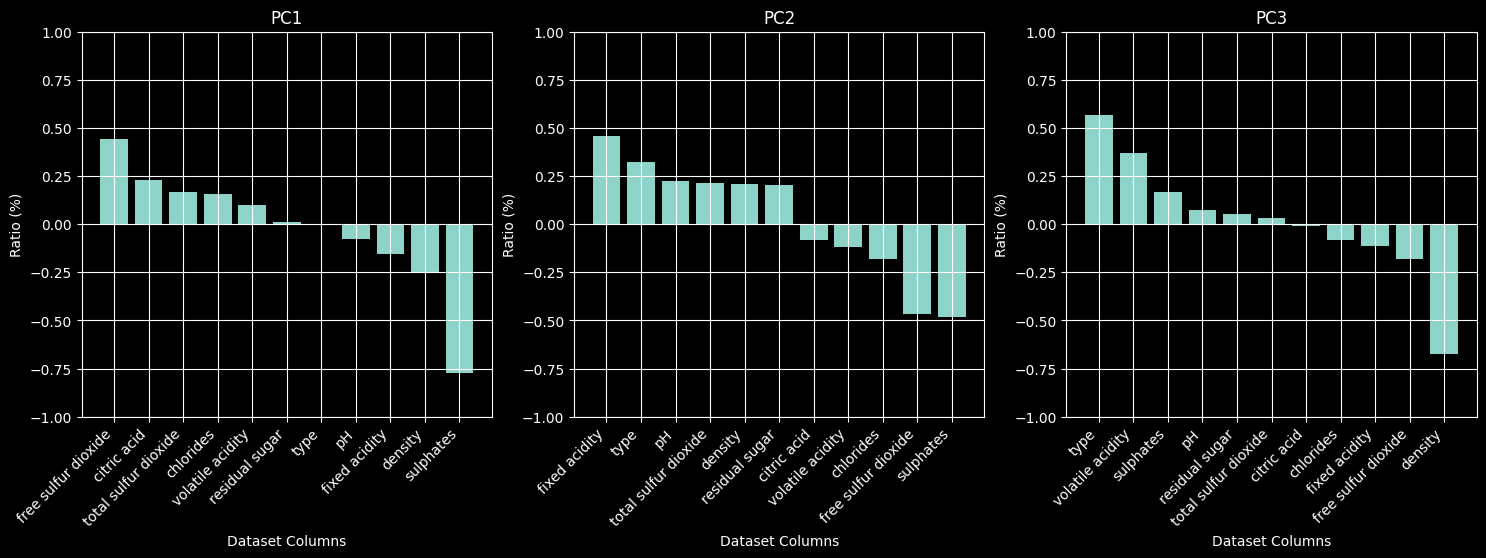

In [15]:
pc1, pc2, pc3 = svd_components[:3]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.set_title("PC1")
ax2.set_title("PC2")
ax3.set_title("PC3")

plot_pc_ratios(ax1, pc1, columns)
plot_pc_ratios(ax2, pc2, columns)
plot_pc_ratios(ax3, pc3, columns)

plt.show()

You might notice that results that SVD gives are quite different from what eigendecomposition gives us. I have no idea why, but this plot looks cooler and is probably more correct.

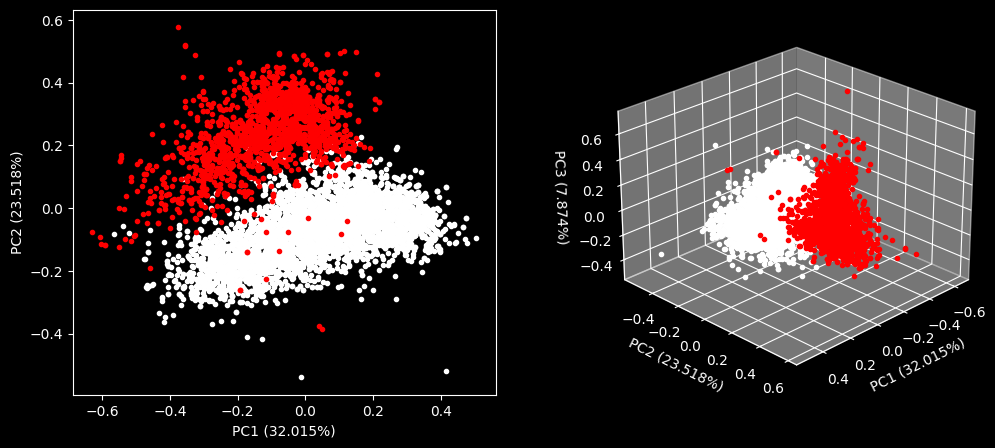

In [16]:
svd_result = np.array([dot_df_pc(df, svd_components[i]) for i in range(3)])

fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(1, 2, 1)

ax.set_xlabel(f"PC1 ({svd_variances[0]}%)")
ax.set_ylabel(f"PC2 ({svd_variances[1]}%)")

ax.plot(*svd_result[:2, WHITE_I], "w.")
ax.plot(*svd_result[:2, RED_I], "r.")


ax = fig.add_subplot(1, 2, 2, projection="3d")

ax.set_xlabel(f"PC1 ({svd_variances[0]}%)")
ax.set_ylabel(f"PC2 ({svd_variances[1]}%)")
ax.set_zlabel(f"PC3 ({svd_variances[3]}%)")

ax.plot(*svd_result[:, WHITE_I], "w.")
ax.plot(*svd_result[:, RED_I], "r.")
ax.view_init(elev=25, azim=45, roll=0)

plt.show()

## PCA with `scikit`

In [17]:
COMPONENTS = 10

pca = decomposition.PCA(n_components=COMPONENTS)
pca = pca.fit(df)

pca_components = pca.components_

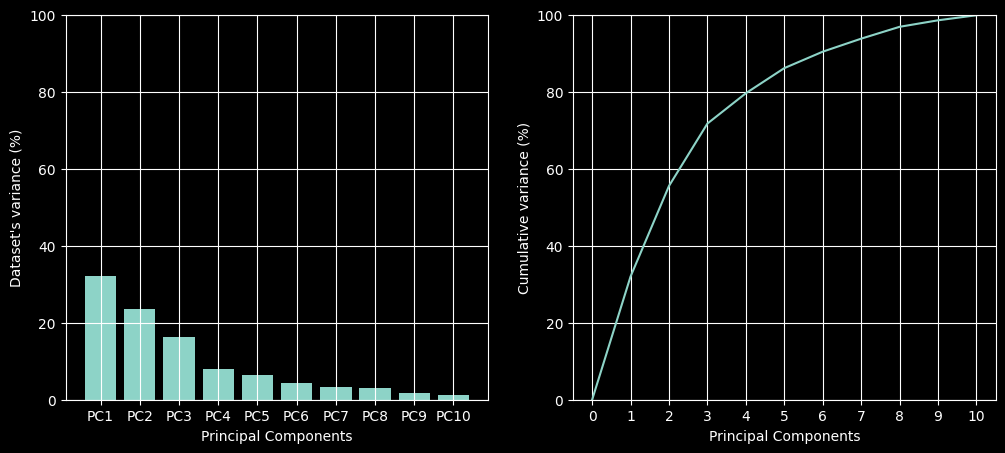

In [18]:
labels = [f"PC{i + 1}" for i in range(COMPONENTS)]
pca_variances = np.round(pca.explained_variance_ratio_ * 100, 3)

plot_pcs_variances(labels, pca_variances)
plt.show()

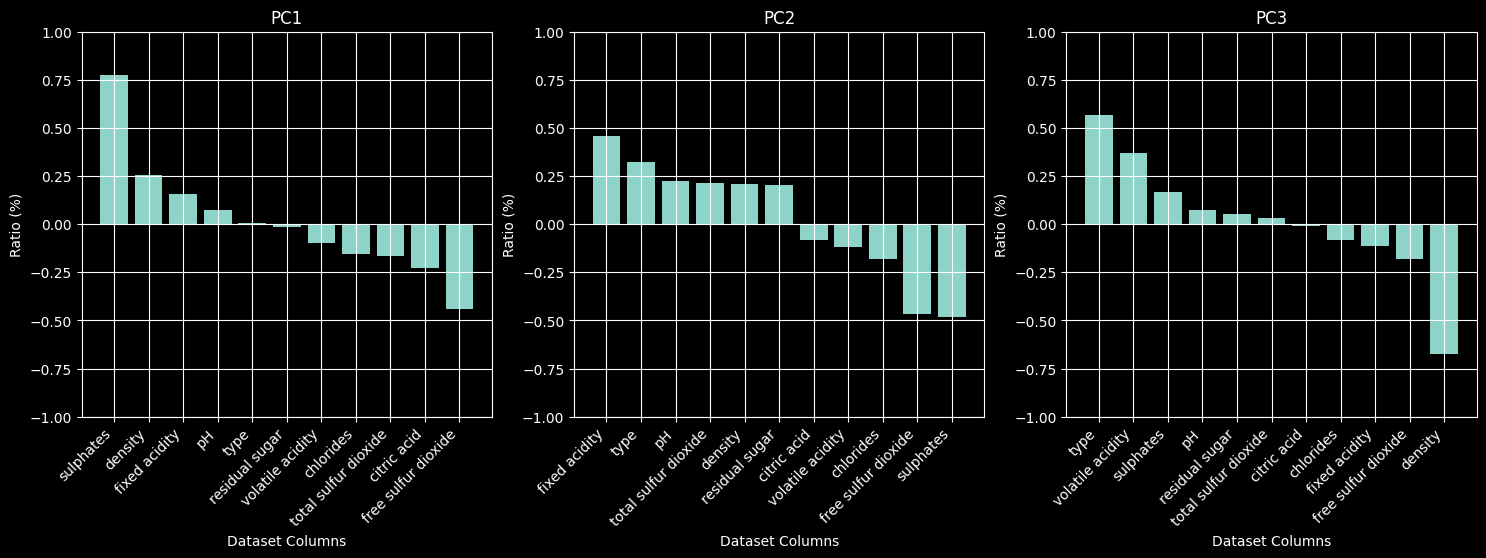

In [19]:
pc1, pc2, pc3 = pca_components[:3]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.set_title("PC1")
ax2.set_title("PC2")
ax3.set_title("PC3")

plot_pc_ratios(ax1, pc1, columns)
plot_pc_ratios(ax2, pc2, columns)
plot_pc_ratios(ax3, pc3, columns)

plt.show()

With `scikit` it's a lot simpler, all you have to do is initiate PCA class and give it normalized data.

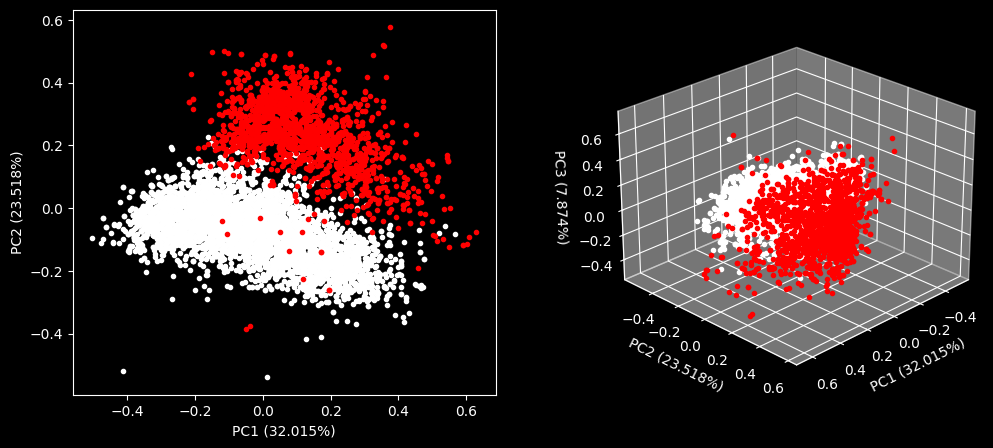

In [20]:
fig = plt.figure(figsize=(12, 5))

pca = decomposition.PCA(n_components=2)
pca.fit(df)
pca_result_2d = pca.transform(df).T

ax = fig.add_subplot(1, 2, 1)

ax.set_xlabel(f"PC1 ({pca_variances[0]}%)")
ax.set_ylabel(f"PC2 ({pca_variances[1]}%)")

ax.plot(*pca_result_2d[:, WHITE_I], "w.")
ax.plot(*pca_result_2d[:, RED_I], "r.")


pca = decomposition.PCA(n_components=3)
pca.fit(df)
pca_result_3d = pca.transform(df).T

ax = fig.add_subplot(1, 2, 2, projection="3d")

ax.set_xlabel(f"PC1 ({pca_variances[0]}%)")
ax.set_ylabel(f"PC2 ({pca_variances[1]}%)")
ax.set_zlabel(f"PC3 ({pca_variances[3]}%)")

ax.plot(*pca_result_3d[:, WHITE_I], "w.")
ax.plot(*pca_result_3d[:, RED_I], "r.")
ax.view_init(elev=25, azim=45, roll=0)

plt.show()

## Comparison

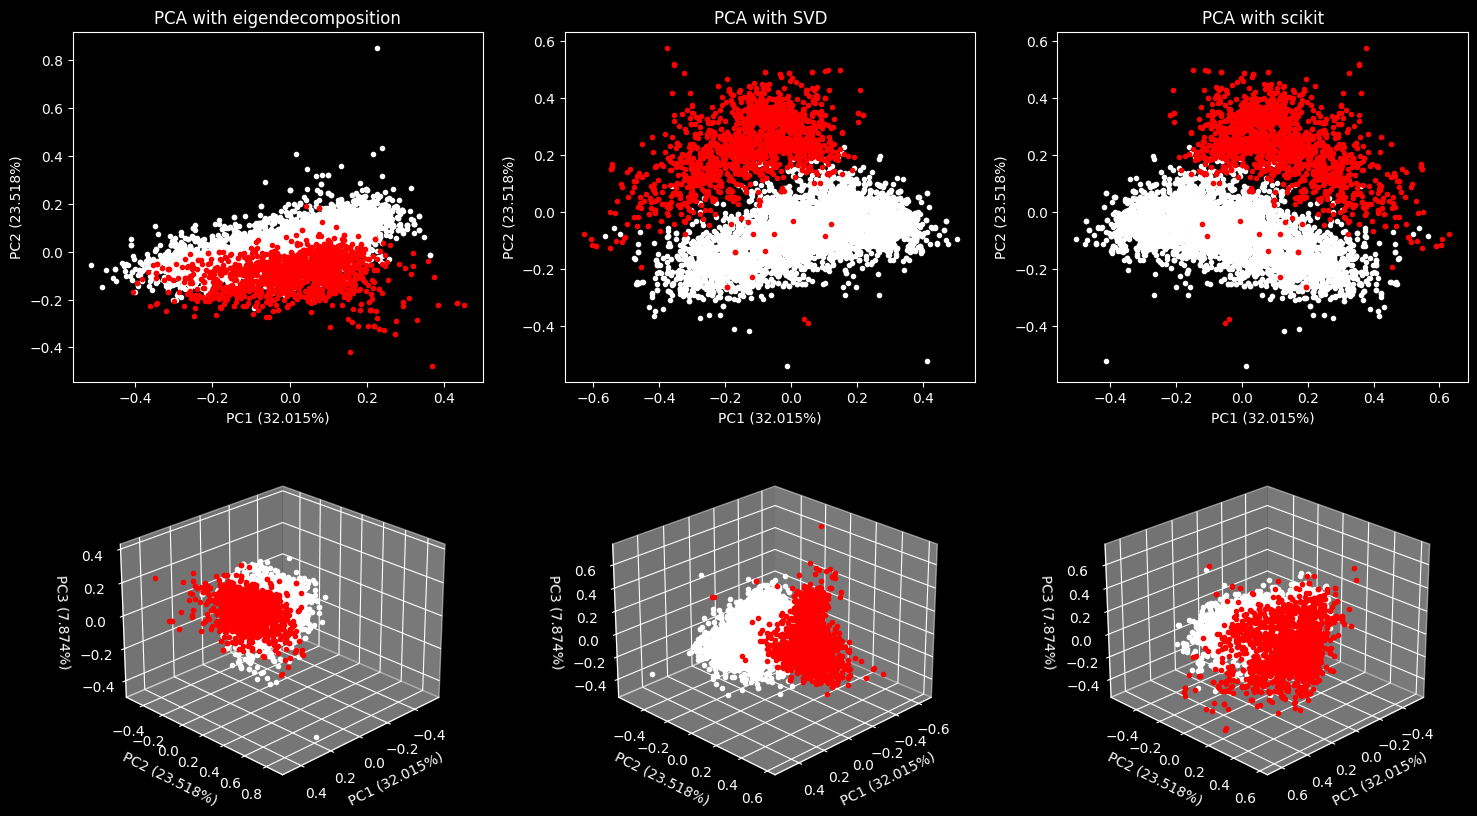

In [21]:
fig = plt.figure(figsize=(18, 10))

# EIGEN

ax = fig.add_subplot(2, 3, 1)
ax.set_title("PCA with eigendecomposition")

ax.set_xlabel(f"PC1 ({eig_variances[0]}%)")
ax.set_ylabel(f"PC2 ({eig_variances[1]}%)")

ax.plot(*eig_result[:2, WHITE_I], "w.")
ax.plot(*eig_result[:2, RED_I], "r.")


ax = fig.add_subplot(2, 3, 4, projection="3d")

ax.set_xlabel(f"PC1 ({eig_variances[0]}%)")
ax.set_ylabel(f"PC2 ({eig_variances[1]}%)")
ax.set_zlabel(f"PC3 ({eig_variances[3]}%)")

ax.plot(*eig_result[:, WHITE_I], "w.")
ax.plot(*eig_result[:, RED_I], "r.")
ax.view_init(elev=25, azim=45, roll=0)

# SVD

ax = fig.add_subplot(2, 3, 2)
ax.set_title("PCA with SVD")

ax.set_xlabel(f"PC1 ({svd_variances[0]}%)")
ax.set_ylabel(f"PC2 ({svd_variances[1]}%)")

ax.plot(*svd_result[:2, WHITE_I], "w.")
ax.plot(*svd_result[:2, RED_I], "r.")


ax = fig.add_subplot(2, 3, 5, projection="3d")

ax.set_xlabel(f"PC1 ({svd_variances[0]}%)")
ax.set_ylabel(f"PC2 ({svd_variances[1]}%)")
ax.set_zlabel(f"PC3 ({svd_variances[3]}%)")

ax.plot(*svd_result[:, WHITE_I], "w.")
ax.plot(*svd_result[:, RED_I], "r.")
ax.view_init(elev=25, azim=45, roll=0)

# SCIKIT

ax = fig.add_subplot(2, 3, 3)
ax.set_title("PCA with scikit")

ax.set_xlabel(f"PC1 ({pca_variances[0]}%)")
ax.set_ylabel(f"PC2 ({pca_variances[1]}%)")

ax.plot(*pca_result_2d[:, WHITE_I], "w.")
ax.plot(*pca_result_2d[:, RED_I], "r.")


ax = fig.add_subplot(2, 3, 6, projection="3d")

ax.set_xlabel(f"PC1 ({pca_variances[0]}%)")
ax.set_ylabel(f"PC2 ({pca_variances[1]}%)")
ax.set_zlabel(f"PC3 ({pca_variances[3]}%)")

ax.plot(*pca_result_3d[:, WHITE_I], "w.")
ax.plot(*pca_result_3d[:, RED_I], "r.")
ax.view_init(elev=25, azim=45, roll=0)

plt.show()

As you noticed, `scikit` and SVD look similar. That's because `scikit` actually uses SVD, but it also changes signs of principal components with largest negative values, for the purpose of deterministic output.

## Conclusion

While it was a fun exercise, and I even managed to get a *similar* result to the one `scikit` outputs,
I would definitely recommend using a ready implementation of PCA for any real-world applications of it.